# EXAM

**Objective:** classify the tweets about Corona Virus as positive or negative; in the dataset there are 5 classes: `'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'`, you will have to eliminate neutral and convert the rest into positive and negative.

1. Exploratory Data Analsis (EDA): look closely at you data, the text, the target, any null values, any imbalance, non-numerical data to be converted (in data and target)?, etc.
2. Split the train set into Training,  Validation, & validation sets (0.75, 0.21), the test set is a separate file here.
3. Clean Textual Data
4. Vectorize Texts (one hot encoder, tfidf, embeddings (word2vec with gensim, ELMO, BERT, GPT, etc.))
5. ML Classification model(s) or DL model or an ensemble of several ML/DL or both ML and DL models
6. Choose and justify the choice of the evaluation metric
7. Hyperparameter optimization (Cross validation - hyperopt - Gridsearch)
8. Evaluate on Test set
9. Use Lime to explain one text classification
10. Use Shapley to explain globally the text classification

**Comment all your steps: justify your choices, analyze the results (whether positive or negative), and finally conclude by suggesting improvements and making recommendations.**

You can use one notebook for all your work or seperate the EDA from the training and finally the testing and interpretability. <br>
You can also use .py scripts (classes/functions) and initialize/call them from the notebook. <br>

The goal is to check that you understood how does an NLP data science project starts. <br>
you will be evaluated on the methods used and **the comments and analysis** you will provide. <br>
Bad test performance will not influence your grade as long as you propose improvements and elaborate on the reasons you think might have influenced this bad results. <br>

**NB:**
- Imbalance can be fixed by Over/Under sampling and Data Augmentation.<br> Using Textual Data Augmentation techniques (libraries like textattack.augmentation, NLPAug, backtranslations, etc.,) would be a bonus if used.
- Another bonus is granted if you keep the problem a multi-class classification instead of a binary one; the classes woul be:`'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'`

I have already started the EDA section for you.


## Imports


In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from tqdm import tqdm

tqdm.pandas()
import warnings

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [25]:
import re
import spacy

spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [63]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.3 MB/s eta 0:00:00


## 1. Dataset

In [26]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/nlp/TP Exam"

### Load train and test datasets

In [27]:
train_df = pd.read_csv(os.path.join(folder_path, 'data/Corona_NLP_train.csv'), encoding='latin')
test_df = pd.read_csv(os.path.join(folder_path, 'data/Corona_NLP_test.csv'), encoding='latin')

# change column names to lowercase
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
print(f"> Train shape: {train_df.shape}")
print(f"> Test shape: {test_df.shape}")
print(f"> Columns: {train_df.columns}")
train_df

> Train shape: (41157, 6)
> Test shape: (3798, 6)
> Columns: Index(['username', 'screenname', 'location', 'tweetat', 'originaltweet',
       'sentiment'],
      dtype='object')


,username,screenname,location,tweetat,originaltweet,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


### Overview

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       41157 non-null  int64 
 1   screenname     41157 non-null  int64 
 2   location       32567 non-null  object
 3   tweetat        41157 non-null  object
 4   originaltweet  41157 non-null  object
 5   sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       3798 non-null   int64 
 1   screenname     3798 non-null   int64 
 2   location       2964 non-null   object
 3   tweetat        3798 non-null   object
 4   originaltweet  3798 non-null   object
 5   sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


## 2. EDA

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.

### Missing Values

Now let us check for missing values in the dataset.

In [30]:
train_df.isnull().sum()

username            0
screenname          0
location         8590
tweetat             0
originaltweet       0
sentiment           0
dtype: int64

In [31]:
columns_without_target_col = train_df.columns.drop('sentiment')
# column without missing values
train_df[columns_without_target_col].isnull().sum() / len(train_df) * 100

username          0.000000
screenname        0.000000
location         20.871298
tweetat           0.000000
originaltweet     0.000000
dtype: float64

In [32]:
test_df[columns_without_target_col].isnull().sum() / len(test_df) * 100

username          0.000000
screenname        0.000000
location         21.958926
tweetat           0.000000
originaltweet     0.000000
dtype: float64

### Duplicate Values

In [33]:
train_df.duplicated().sum()

0

In [34]:
test_df.duplicated().sum()

0

In [35]:
train_df["originaltweet"].duplicated().sum()

0

In [36]:
test_df["originaltweet"].duplicated().sum()

0

### Target Distribution

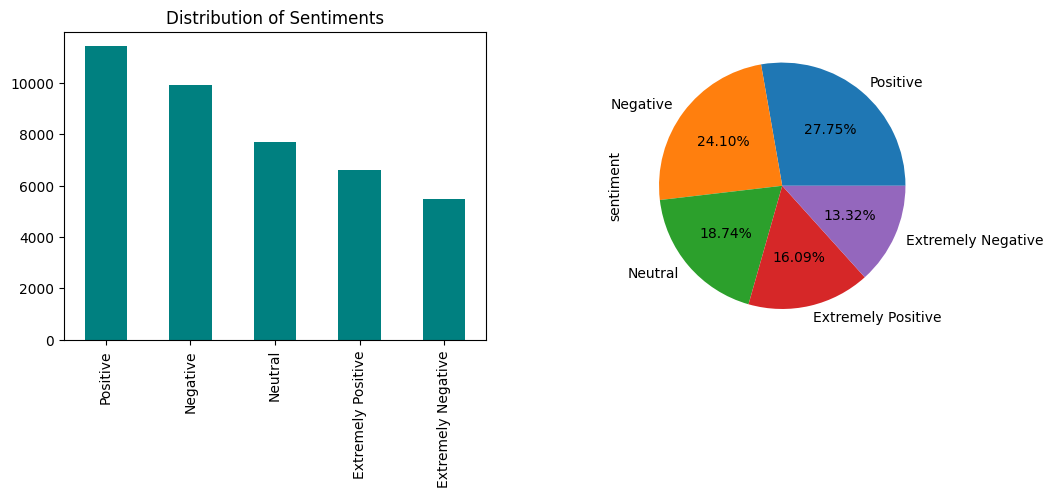

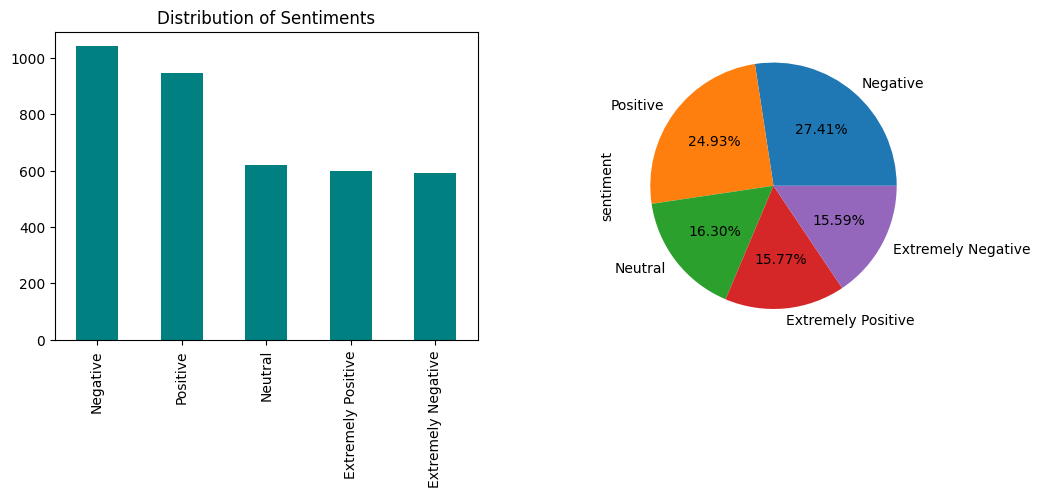

In [37]:
for df in [train_df, test_df]:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)

    df.sentiment.value_counts().plot.bar(ax=axes[0], color='teal')
    axes[0].set_title('Distribution of Sentiments')

    df.sentiment.value_counts().plot.pie(ax=axes[1], autopct='%1.2f%%')
    plt.show()

About the exploratory data analysis,

Firstly, we can see that there are no missing values in the dataset.

Secondly, we can see that there are no duplicate values in the dataset.

Finally, we can see that the dataset is imbalanced, we will have to fix this later.

## 3. Clean Textual Data

In [38]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the words
    text = text.lower()
    # Lemmatize each word
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.lemma_ and not token.is_stop and not token.is_punct])
    return text


# Clean the tweets
train_df['originaltweet_clean'] = train_df['originaltweet'].progress_apply(lambda x: clean_text(x))
# Save
train_df.to_csv(os.path.join(folder_path, 'data/train_clean.csv'), index=False)
train_df

100%|██████████| 41157/41157 [07:49<00:00, 87.65it/s] 


,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth elderly disabl...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock \r\r\n\r\r\n not panic food need \r...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket covid19 outbreak \r\r\n\r\r\...
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilot offer stock supermarket shelf nz...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provide cite covid19 relate...
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know itâs get tough ration toilet paper cor...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer start turn \r\r\n\r...


In [39]:
test_df['originaltweet_clean'] = test_df['originaltweet'].progress_apply(lambda x: clean_text(x))
test_df.to_csv(os.path.join(folder_path, 'data/test_clean.csv'), index=False)
test_df

100%|██████████| 3798/3798 [00:42<00:00, 90.33it/s]


,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trend new yorker encounter supermarket shelf p...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,not find hand sanitizer fred meyer turn amazon...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect love one coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hit newyork city anxious shopper ...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,supermarket israel people dance sing stay po...
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,panic buy lot nonperishable item echo need foo...
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof economic talk recent research co...
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need something instead biar je rakyat assu...


About the cleaning of data,

Firstly, we can see that we have removed the URLs, the user @ references, the hashtags from the tweets, and we have removed the punctuations and lowercased the words. Finally, we can see that we have lemmatized each word.


## 4. Vectorize Texts



In [40]:
train_df.head()
# classe to number
for df in [train_df, test_df]:
    df['sentiment'] = df['sentiment'].map(
        {'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 0, 'Neutral': 0, 'Positive': 1})

train_df.head()

,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,coronavirus australia woolworth elderly disabl...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1,food stock \r\r\n\r\r\n not panic food need \r...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,ready supermarket covid19 outbreak \r\r\n\r\r\...


<Axes: ylabel='sentiment'>

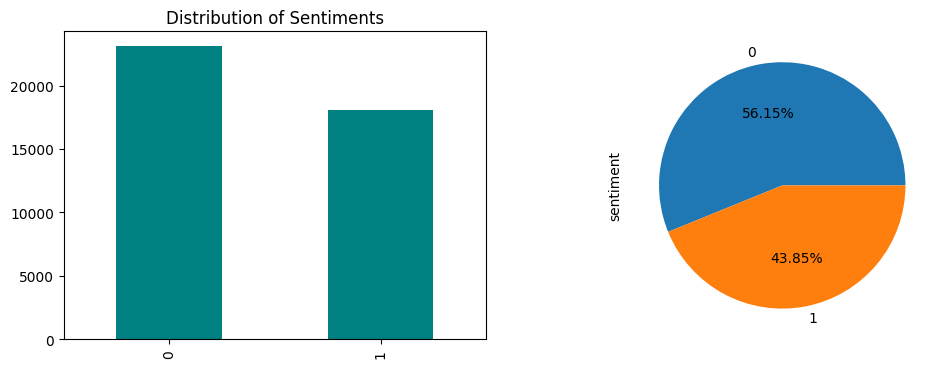

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)

train_df.sentiment.value_counts().plot.bar(ax=axes[0], color='teal')
axes[0].set_title('Distribution of Sentiments')

train_df.sentiment.value_counts().plot.pie(ax=axes[1], autopct='%1.2f%%')

### TF-IDF

We will use TF-IDF vectorizer to vectorize the texts.

TF-IDF stands for Term Frequency - Inverse Document Frequency. It is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### Transform features

In [43]:
# Transform features
X_train = train_df.originaltweet_clean
X_tfidf_train = vectorizer.fit_transform(X_train)
X_test = test_df.originaltweet_clean
X_tfidf_test = vectorizer.transform(X_test)

# Get the target
y_train = train_df.sentiment
y_test = test_df.sentiment

In [44]:
print('> Before vectorization:', len(X_train[2]))
print('> After vectorization:', X_tfidf_train[2].shape)

print('> Before vectorization:', len(X_train[3]))
print('> After vectorization:', X_tfidf_train[3].shape)

> Before vectorization: 94
> After vectorization: (1, 5000)
> Before vectorization: 158
> After vectorization: (1, 5000)


About the vectorization of texts,

Firstly, we can see that we have vectorized the texts using TF-IDF vectorizer with a vector size of 3567

## 5. Machine Learning Model

### Random Forest

#### Hyperparameter Tuning

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create the basic parameter grid based on the results of random search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create a based model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
best_rf = grid_search.fit(X_tfidf_train, y_train)
best_rf


Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

#### Train

In [46]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(**best_rf.best_params_)

# Fit the model to the training data
rf.fit(X_tfidf_train, y_train)

RandomForestClassifier(max_depth=30, max_features='auto', n_estimators=300)

#### Evaluate

Accuracy:  0.7601369141653502 

Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.92      0.82      2252
           1       0.82      0.52      0.64      1546

    accuracy                           0.76      3798
   macro avg       0.78      0.72      0.73      3798
weighted avg       0.77      0.76      0.75      3798
 

Confusion Matrix:


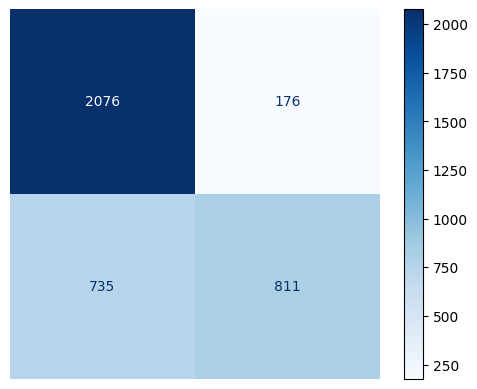

In [58]:
# Predict
y_pred = rf.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()

### Logistic Regression

#### Hyperparameter Tuning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create the basic parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

# Create a based model
logreg = LogisticRegression(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
best_logreg = grid_search.fit(X_tfidf_train, y_train)
best_logreg

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
             verbose=2)

#### Train

In [49]:
# Initialize the Logistic Regression Classifier
logreg = LogisticRegression(**best_logreg.best_params_)

# Fit the model to the training data
logreg.fit(X_tfidf_train, y_train)

LogisticRegression(C=10)

#### Evaluate

Accuracy:  0.8467614533965245 

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      2252
           1       0.82      0.80      0.81      1546

    accuracy                           0.85      3798
   macro avg       0.84      0.84      0.84      3798
weighted avg       0.85      0.85      0.85      3798
 

Confusion Matrix:


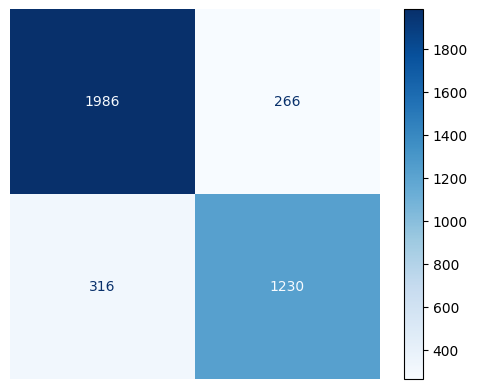

In [50]:
# Predict
y_pred = logreg.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=logreg.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()


### XGBoost

#### Hyperparameter Tuning

In [51]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Create the basic parameter grid based on the results of random search
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

# Create a based model
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
best_xgb = grid_search.fit(X_tfidf_train, y_train)
best_xgb

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

#### Train

In [52]:
    # Initialize the XGBClassifier
xgb = XGBClassifier(**best_xgb.best_params_)

# Fit the model to the training data
xgb.fit(X_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
#### Evaluate

Accuracy:  0.8080568720379147 

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      2252
           1       0.81      0.69      0.75      1546

    accuracy                           0.81      3798
   macro avg       0.81      0.79      0.80      3798
weighted avg       0.81      0.81      0.81      3798
 

Confusion Matrix:


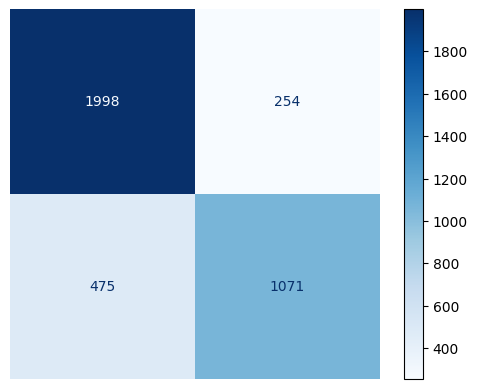

In [54]:
# Predict
y_pred = xgb.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=xgb.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()

Résumé :
- Random Forest :

    - Accuracy: 0.76
    - Precision (Classe 0): 0.74, Precision (Classe 1): 0.82
    - Recall (Classe 0): 0.92, Recall (Classe 1): 0.52
    - F1-Score (Classe 0): 0.82, F1-Score (Classe 1): 0.64

- Régression Logistique :

    - Accuracy: 0.84
    - Precision (Classe 0): 0.86, Precision (Classe 1): 0.82
    - Recall (Classe 0): 0.88, Recall (Classe 1): 0.80
    - F1-Score (Classe 0): 0.87, F1-Score (Classe 1): 0.81

- XGBoost :
    - Accuracy: 0.81
    - Precision (Classe 0): 0.81, Precision (Classe 1): 0.81
    - Recall (Classe 0): 0.89, Recall (Classe 1): 0.69
    - F1-Score (Classe 0): 0.85, F1-Score (Classe 1): 0.75

## 6. Selection of the best model

Nous allons nous basons sur l'évaluation précédentes et l'analyse des métriques pour choisir le meilleur modele.

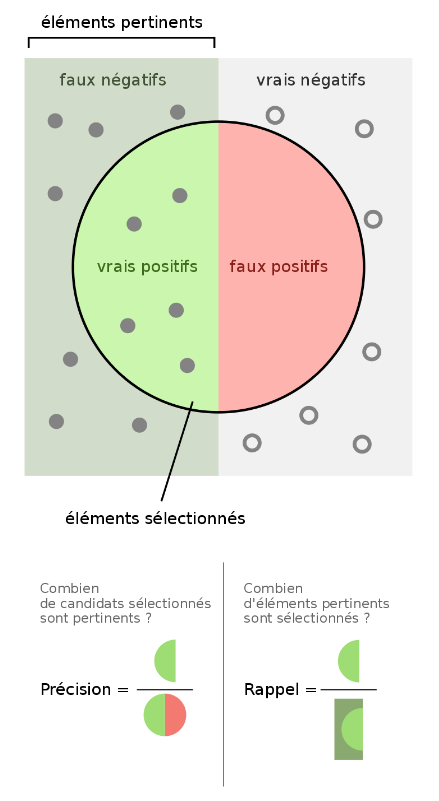

Analyse :

- Concernant l'Accuracy: La régression logistique a le score d'accuracy le plus élevé parmi les trois modèles, ce qui suggère qu'elle a correctement prédit un plus grand nombre de résultats sur l'ensemble des données de test.
- Concernant la Precision: La régression logistique montre une meilleure precision pour la classe 1 que Random Forest et des performances comparables à XGBoost pour les deux classes.
- Concernant le Recall: La régression logistique a un recall plus équilibré entre les deux classes par rapport aux autres modèles.
- Concernant le F1-Score: C'est la moyenne harmonique de precision et recall, et prend en compte à la fois les faux positifs et les faux négatifs. La régression logistique présente les scores F1 les plus élevés pour les deux classes, ce qui signifie qu'elle maintient un bon équilibre entre precision et recall.
- Concernant la Matrice de Confusion: La régression logistique semble avoir un nombre plus équilibré de vrais positifs et vrais négatifs pour les deux classes, avec moins de faux positifs et faux négatifs par rapport à Random Forest et à XGBoost.

Sur la base des métriques, la régression logistique semble être le modèle le plus performant. Elle a non seulement l'accuracy la plus élevée, mais aussi le meilleur équilibre entre precision et recall, ce qui est crucial dans des situations où les coûts des faux positifs et des faux négatifs sont importants. De plus, les scores F1 élevés indiquent que le modèle de régression logistique est robuste et équilibré dans sa performance sur les deux classes.

In [55]:
# New test
new_test = ['I am happy', 'I am sad', 'I am angry', 'I am not happy', 'I am not sad', 'I am not angry']

# Vectorize the new test set
X_new_test = vectorizer.transform(new_test)

# Predict the new test set
y_pred = logreg.predict(X_new_test)

# Print the predictions
for pred, text in zip(y_pred, new_test):
    print(f'{text} --> {pred}')

I am happy --> 1
I am sad --> 0
I am angry --> 0
I am not happy --> 1
I am not sad --> 0
I am not angry --> 0


On peut s'apercevoir que le modèle prédit bien les sentiments des phrases. Cepandant, parfois il ne semble pas prendre en compte la négation des phrases.

In [56]:
# Save the best model
import joblib

joblib.dump(logreg, os.path.join(folder_path, 'models/logreg_model_corona.pkl'))

['/content/drive/MyDrive/Colab Notebooks/nlp/TP Exam/models/logreg_model_corona.pkl']

## 7. Use LIME to explain one text classification

In [60]:
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

In [61]:
# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Choisissez une observation spécifique (par exemple, la première dans X_test)
observation_idx = 1  # Changez l'indice si nécessaire

# Choose a random text from the test set
text = X_test.iloc[observation_idx]

print('Text: ', text)

# Function to make predictions with the logistic regression model
def predict_proba(texts):
    tfidf_texts = vectorizer.transform(texts)
    return logreg.predict_proba(tfidf_texts)

# Explain the prediction
explanation = explainer.explain_instance(text, predict_proba, num_features=6)

# Show the explanation in the notebook
explanation.show_in_notebook(text=True)

# Print the explanation
print(explanation.as_list())

Text:  not find hand sanitizer fred meyer turn amazon 11497 2 pack purellcheck   coronavirus concern drive price


[('hand', 0.507380171831969), ('amazon', 0.15846097080917357), ('turn', -0.04453971096292236), ('sanitizer', 0.04143621922623178), ('price', -0.034509808212457596), ('drive', -0.031342116636633166)]


Selon LIME, le modèle a prédit que le texte était positif en raison des mots : 'hand', 'amazon', et 'sanitizer'. C'est très étrange comme raison car au prime abord ces mots ne sont pas chargés positivement. Voilà pourquoi nous allons procéder à d'autres tests

Étant donné que nous disposons d'un pipeline capable de vectoriser n'importe quel texte, nous allons procéder à des expériences :
- Expérience 1 : nous allons donner au modèle une phrase avec des adjectifs positifs
- Expérience 2 : nous allons donner au modèle une phrase avec des adjectifs négatifs
- Expérience 3 : nous donnons au modèle une phrase avec des mots qui ne lui sont pas familiers

In [82]:
# Définition des phrases pour les expériences
experiment_phrases = [
    "This is an amazing, excellent product with great features.",
    "This is a terrible, bad product with horrible features.",
    "Ismy Mlachahe ibn Salim, wa ana la uhibb jamal al-hayat."
]

# Pour chaque phrase, calculez les valeurs LIME et plot
for i, phrase in enumerate(experiment_phrases):
    print('Text:', phrase)
    explanation_1 = explainer.explain_instance(phrase, predict_proba, num_features=6)
    explanation_1.show_in_notebook(text=True)

Output hidden; open in https://colab.research.google.com to view.

- Concernant l'expérience 1 : le modèle a prédit que le texte était positif en raison des mots : 'great', 'excellent', et 'amazing' qui sont très chargés.
- Concernant l'expérience 2 : le modèle a prédit que le texte était négatif en raison des mots : 'terrible', 'bed', et 'horrible' qui sont assez chargés
- Concernant l'expérience 3 : le modèle a prédit ni l'un ni l'autre. Cela est du au faite que les mots qui influencent ne sont pas pertinent

## 8. Use SHAP to explain globally the text classification

In [64]:
import shap

  0%|          | 0/50 [00:00<?, ?it/s]

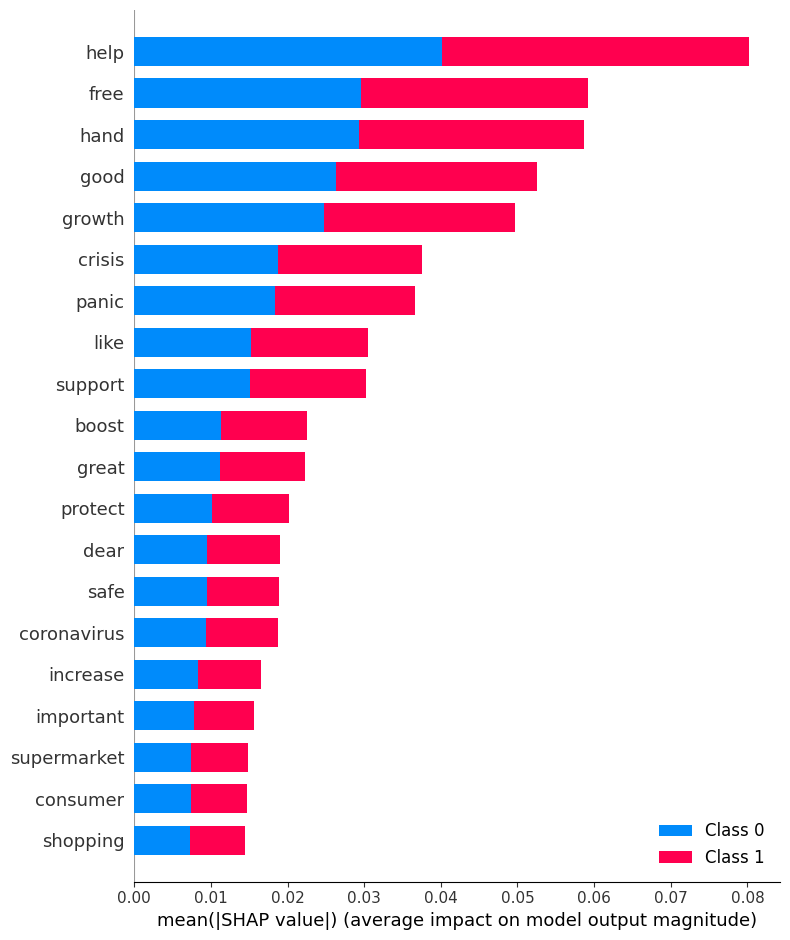

In [65]:
# Résumez les données d'entraînement avec kmeans pour l'explainer SHAP
x_summary = shap.kmeans(X_tfidf_train, 10)

# Initialisez l'explainer SHAP pour la régression logistique
shap_explainer = shap.KernelExplainer(logreg.predict_proba, x_summary)

# Calculez les valeurs SHAP pour un échantillon de données de test
X_test_sampled = shap.sample(X_tfidf_train, 50)  # Prend un échantillon de 50 données de test
shap_values = shap_explainer.shap_values(X_test_sampled, nsamples=100)  # nsamples est le nombre de fois où chaque observation est rééchantillonnée

# Affichez le graphique résumé SHAP
shap.summary_plot(shap_values, X_test_sampled, feature_names=vectorizer.get_feature_names_out())

Ce graphique SHAP montre l'impact de chaque caractéristique (mot) sur les prédictions du modèle pour deux classes distinctes, Class 0 (Négative) et Class 1 (Positive).

Dans votre notre cas, on peut observer par exemple :

- Le mot "help" a un impact significatif et positif sur la classe 1 (Positive), mais un impact négatif sur la classe 0 (Négative).
- Le mot "shopping" a également un impact sur les deux classes mais dans des directions opposées, avec un effet plus marqué sur la classe 1 (Positive).
- Des mots comme "crisis" et "panic" semblent avoir un impact important et plutôt unilatéral sur la classe 1 (Positive).

Ensuite, nous allons réitérer les expérience précédentes.

  0%|          | 0/1 [00:00<?, ?it/s]

Text: This is an amazing, excellent product with great features.


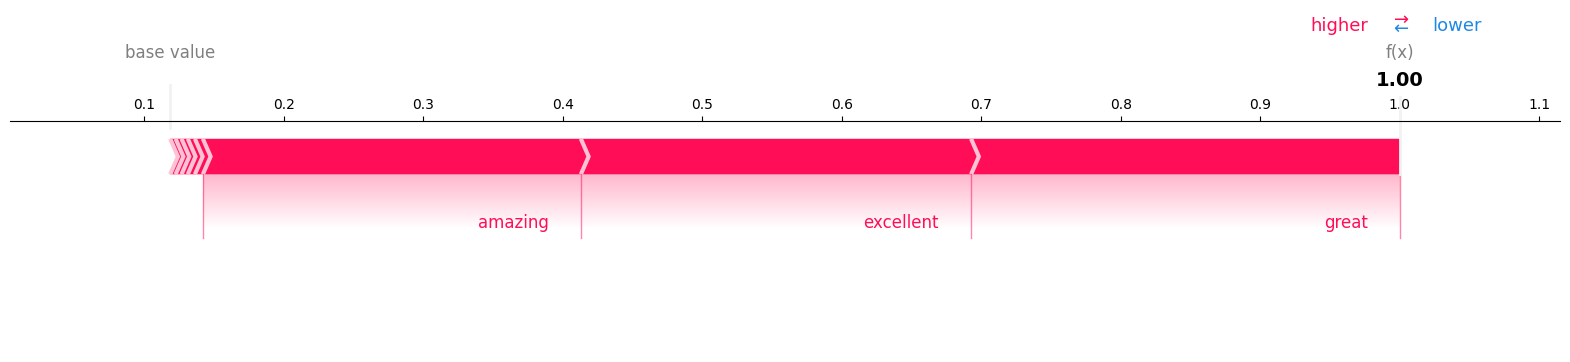

  0%|          | 0/1 [00:00<?, ?it/s]

Text: This is a terrible, bad product with horrible features.


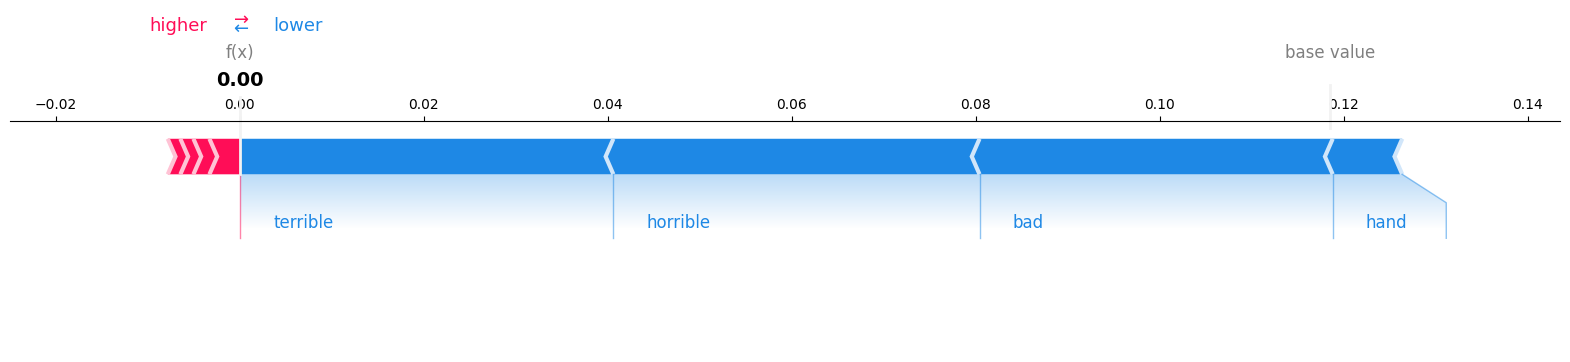

  0%|          | 0/1 [00:00<?, ?it/s]

Text: Ismy Mlachahe ibn Salim, wa ana la uhibb jamal al-hayat.


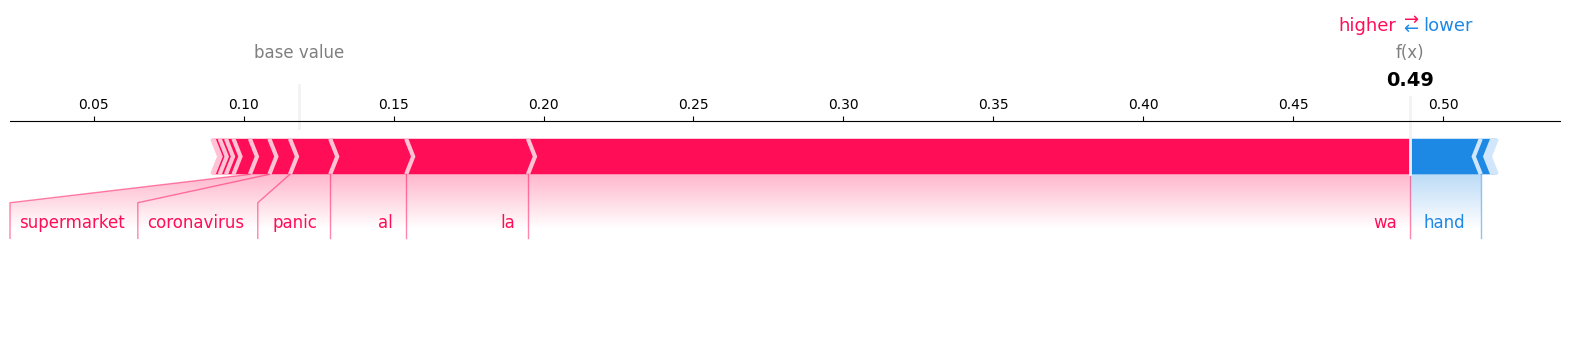

In [83]:
# Définition des phrases pour les expériences
experiment_phrases = [
    "This is an amazing, excellent product with great features.",
    "This is a terrible, bad product with horrible features.",
    "Ismy Mlachahe ibn Salim, wa ana la uhibb jamal al-hayat."
]


# Initialisation de SHAP JavaScript (nécessaire pour la visualisation)
shap.initjs()

# Pour chaque phrase, calculez les valeurs SHAP et créez un force plot
for i, phrase in enumerate(experiment_phrases):
    # Vectorisation des phrases
    vectorized_phrase = vectorizer.transform([phrase])

    # Calculez les valeurs SHAP pour la phrase vectorisée
    shap_value = shap_explainer.shap_values(vectorized_phrase)

    # Affichez le texte de la phrase
    print(f'Text: {phrase}')

    # Créez le force plot pour cette phrase
    force_plot = shap.force_plot(
        shap_explainer.expected_value[1],
        shap_value[1],
        feature_names=vectorizer.get_feature_names_out(),
        matplotlib=True
    )


- Concernant l'expérience 1 :
    - peut être interprété comme la probabilité de la classe de base avant que l'effet de toutes les caractéristiques individuelles soit pris en compte. La valeur prédite (f(x)) est de 1.00, ce qui suggère très probablement une prédiction de classe 1 (positive).
    - Chaque mot ("amazing", "excellent", "great") pousse la prédiction vers une probabilité plus élevée de la classe cible (positive), car ils sont tous situés à droite de la base value et colorés en rouge.

- Concernant l'expérience 2 :
    - La base value et la valeur prédite (f(x)) semble être proche de 0, ce qui pourrait être le seuil de décision entre deux classes.
    - Les mots ("terrible", "horrible", "bad") poussent la prédiction vers la classe 0 (négative), comme indiqué par leur position à gauche de la base value et leur couleur bleue.


- Concernant l'expérience 3 :
    - La base value est proche de 0.05, et la valeur prédite (f(x)) est de 0.49, indiquant une prédiction moins certaine, peut-être en raison de l'ambiguïté, mais c'est surement dû au manque de reconnaissance de ces mots (de l'arabe phonétique).
    - On voit que les mots comme "wa" et "al" poussent la prédiction vers la classe 1, mais c'est aussi le cas pour "supermarket" et "coronavirus" qui semblent avoir un impact significatif sur la prédiction alors qu'il ne sont même pas dans la phrase d'entrée ; tout cela tandis que "hand" (absent aussi, c'est étrange) semble avoir un effet contraire, réduisant la probabilité prédite.

